In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from empiricalgalo import utils, models

%load_ext autoreload
%autoreload 2

try:
    # Disable all GPUS
    tf.config.set_visible_devices([], 'GPU')
    visible_devices = tf.config.get_visible_devices()
    for device in visible_devices:
        assert device.device_type != 'GPU'
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

In [2]:
data = np.load("../data/HAGNmatch.npy")

m = (data["H_level"] == 1) & (data["H_mhalo"] > 1e10) & (data["G_mgal"] > 1e9)
data = data[m]


features = ["H_mhalo", "H_concentration", "H_spin"]
log_features = ["H_mhalo", "H_concentration", "H_spin"]

target = "G_mgal"

In [3]:
Xtrain, Xtest, ytrain, ytest = utils.stratify_split(data, features, target, target, True)

In [4]:
from sklearn.preprocessing import StandardScaler

In [5]:
# features_pipe = Pipeline([('selector', utils.DataFrameSelector(features, log_features)),
#                           ('PCA', PCA(whiten=True, n_components=len(features)))])
features_pipe = Pipeline([('selector', utils.DataFrameSelector(features, log_features)),
                          ('scaler', StandardScaler())])
target_pipe = Pipeline([('selector', utils.DataFrameSelector(target, target))])

In [6]:
Xtrain, Xtest = utils.apply_preprocess(Xtrain, Xtest, features_pipe)
ytrain, ytest = utils.apply_preprocess(ytrain, ytest, target_pipe)

In [7]:
Ninputs = len(features)
checkpoint_dir = "./checkpoints"

batch_size = 500
steps_per_epoch = len(ytrain) // batch_size

model = models.GaussianLossNN(Ninputs, checkpoint_dir)

schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.004, decay_steps=3000, decay_rate=1.3)

clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=0.001,
    maximal_learning_rate=0.01,
    scale_fn=lambda x: 1/(2.**(x-1)),
    step_size=2 * steps_per_epoch
)


optimizer = tf.optimizers.Adamax(learning_rate=clr)

2022-05-08 19:06:19.742854: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [8]:
model.fit(Xtrain, ytrain, batch_size=batch_size, optimizer=optimizer)

2022-05-08 19:06:20.082276: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [9]:
stats = model.predict_stats(Xtest)

In [10]:
model.score_R2mean(Xtest, ytest)

0.9251035579678573

In [11]:
model.score_reduced_chi2(Xtest, ytest)

0.9955718751849335

In [12]:
grad = model.predict_gradient(Xtest)

In [13]:
grad

array([[[ 1.03605008e+00,  1.72307074e-01,  5.62639236e-02],
        [ 6.46245658e-01,  6.40830994e-02, -3.24754119e-02],
        [ 9.23328519e-01,  1.77188396e-01, -4.38833237e-02],
        ...,
        [ 7.40495503e-01,  1.44428432e-01, -1.11528322e-01],
        [ 3.07741299e-01,  3.44804585e-01, -2.70448923e-02],
        [ 6.97233737e-01,  1.36083901e-01, -1.10475570e-02]],

       [[-2.68146554e-02, -2.07146583e-02,  3.75318360e-03],
        [-1.94565752e-02, -2.51153600e-02,  6.39445458e-03],
        [-1.91752193e-02, -1.77354710e-02,  2.22258936e-03],
        ...,
        [-1.58516343e-02, -3.06820665e-02, -1.64194437e-03],
        [-1.31057180e-02, -3.14433333e-02,  1.02991281e-02],
        [-4.03922237e-02, -3.98880062e-02,  4.45950371e-04]]])

In [15]:
mu_grad

{'linear_input': <tf.Tensor: shape=(9847, 3), dtype=float64, numpy=
 array([[ 1.0698806 ,  0.34427003, -0.02676497],
        [ 0.49080297,  0.15601809, -0.02182768],
        [ 0.88002521,  0.29177315,  0.0132014 ],
        ...,
        [ 0.805926  ,  0.16912604,  0.00598337],
        [ 0.40682848,  0.08471442, -0.00504727],
        [ 0.65356833,  0.11743264,  0.00666493]])>,
 'deep_input': <tf.Tensor: shape=(9847, 3), dtype=float64, numpy=
 array([[ 1.0698806 ,  0.34427003, -0.02676497],
        [ 0.49080297,  0.15601809, -0.02182768],
        [ 0.88002521,  0.29177315,  0.0132014 ],
        ...,
        [ 0.805926  ,  0.16912604,  0.00598337],
        [ 0.40682848,  0.08471442, -0.00504727],
        [ 0.65356833,  0.11743264,  0.00666493]])>}

In [263]:
np.asarray(mu_grad)

array(None, dtype=object)

In [250]:
Xtestinv = features_pipe.inverse_transform(Xtest)

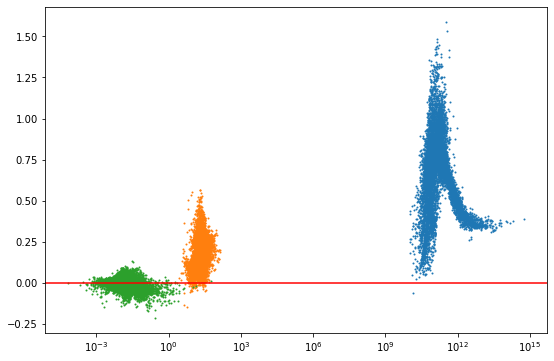

In [252]:
plt.figure(figsize=(9, 6))
for i in range(3):
    plt.scatter(Xtestinv[features[i]], grad[:, i], s=1)
# plt.ylim(-50, 50)

plt.axhline(0, c="red")

plt.xscale("log")
plt.show()

In [22]:
np.sum((stats["mean"] - ytest.reshape(-1,))**2 / stats["std"]**2) / (ytest.size - 2)

1.0485088276052041

In [25]:
ytest.shape

(9847, 1)

In [19]:
z = (stats["mean"] - ytest.reshape(-1,)) / stats["std"]

In [20]:
z

array([-0.40862447,  1.6247173 ,  0.494661  , ...,  1.35488788,
       -0.39358713, -0.69763132])

KeyboardInterrupt: 

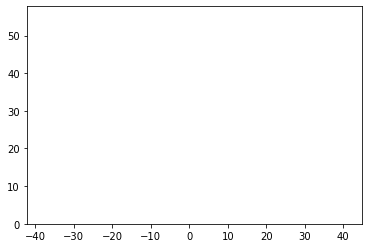

In [32]:
plt.figure()
plt.hist(z, bins="auto")
plt.show()